In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pickle
import pandas as pd

# Path to the selected features file
PATH = "/content/drive/MyDrive/Spotify_Project/5_Data_Selection/spotify_selected_features.pkl"

# Load the DataFrame
with open(PATH, "rb") as f:
    DF_selected = pickle.load(f)

print("Loaded:", DF_selected.shape)
display(DF_selected.head())

Loaded: (32833, 26)


,song_playlist_count,energy,artist_album_count,playlist_song_count,artist_playlist_count,instrumentalness_log,playlist_album_count,playlist_artist_count,playlist_subgenre_progressive electro house,playlist_subgenre_permanent wave,...,release_month,release_day,playlist_name_word_count,album_song_count,acousticness,danceability,playlist_subgenre_hip hop,playlist_subgenre_new jack swing,playlist_subgenre_post-teen pop,track_popularity
0,2,0.916,27,70,37,0.000000,70,48,False,False,...,6,14,2,1,0.1020,0.748,False,False,False,66
1,2,0.815,33,70,31,0.004201,70,48,False,False,...,12,13,2,1,0.0724,0.726,False,False,False,67
2,3,0.931,14,70,20,0.000023,70,48,False,False,...,7,5,2,1,0.0794,0.675,False,False,False,70
3,1,0.930,51,70,53,0.000009,70,48,False,False,...,7,19,2,2,0.0287,0.718,False,False,False,60
4,1,0.833,7,70,11,0.000000,70,48,False,False,...,3,5,2,1,0.0803,0.650,False,False,False,69


In [3]:
from sklearn.model_selection import train_test_split

# Separate target
TARGET = "track_popularity"
y = DF_selected[TARGET]
X = DF_selected.drop(columns=[TARGET])

# First split: Train (70%) + Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)

# Second split: Temp → Dev (15%) + Test (15%)
X_dev, X_test, y_dev, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

print("Train shape:", X_train.shape)
print("Dev shape:", X_dev.shape)
print("Test shape:", X_test.shape)

Train shape: (22983, 25)
Dev shape: (4925, 25)
Test shape: (4925, 25)


In [4]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit on TRAIN only (never on dev/test)
X_train_scaled = scaler.fit_transform(X_train)

# Transform Dev & Test using the same scaler
X_dev_scaled = scaler.transform(X_dev)
X_test_scaled = scaler.transform(X_test)

print("Scaling completed")

Scaling completed


In [5]:

import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# XGBoost
HAS_XGB = False
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    pass

# Define models
models = {
    "Linear": LinearRegression(),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=600, random_state=42, n_jobs=-1),
    "GradientBoost": GradientBoostingRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "KNeighbors": KNeighborsRegressor(n_neighbors=5),
    "SVR": SVR(kernel="rbf"),
}
if HAS_XGB:
    models["XGBoost"] = XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    )

# Metrics helpers
def _safe_rmsle(y_true, y_pred):
    # RMSLE requires non-negative values; use clip + log1p
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    y_true_clip = np.clip(y_true, 0, None)
    y_pred_clip = np.clip(y_pred, 0, None)
    return np.sqrt(np.mean((np.log1p(y_pred_clip) - np.log1p(y_true_clip))**2))

def _all_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    rmsle = _safe_rmsle(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return mse, rmse, mae, rmsle, r2

rows = []
for name, model in models.items():
    # scale-sensitive models use scaled sets
    scale_sensitive = name in ["Linear", "KNeighbors", "SVR"]

    Xtr = X_train_scaled if scale_sensitive else X_train
    Xdv = X_dev_scaled   if scale_sensitive else X_dev
    Xts = X_test_scaled  if scale_sensitive else X_test

    # Fit on TRAIN
    model.fit(Xtr, y_train)

    # Predictions
    pred_tr = model.predict(Xtr)
    pred_dv = model.predict(Xdv)
    pred_ts = model.predict(Xts)

    # Metrics
    tr_mse, tr_rmse, tr_mae, tr_rmsle, tr_r2 = _all_metrics(y_train, pred_tr)
    dv_mse, dv_rmse, dv_mae, dv_rmsle, dv_r2 = _all_metrics(y_dev,   pred_dv)
    ts_mse, ts_rmse, ts_mae, ts_rmsle, ts_r2 = _all_metrics(y_test,  pred_ts)

    rows.append({
        "Model": name,
        "Train_MSE": tr_mse, "Train_RMSE": tr_rmse, "Train_MAE": tr_mae, "Train_RMSLE": tr_rmsle, "Train_R2": tr_r2,
        "Dev_MSE":   dv_mse, "Dev_RMSE":   dv_rmse, "Dev_MAE":   dv_mae, "Dev_RMSLE":   dv_rmsle, "Dev_R2":   dv_r2,
        "Test_MSE":  ts_mse, "Test_RMSE":  ts_rmse, "Test_MAE":  ts_mae, "Test_RMSLE":  ts_rmsle, "Test_R2":  ts_r2,
    })

results_all = pd.DataFrame(rows).sort_values("Dev_R2", ascending=False)
pd.set_option("display.precision", 4)
print(results_all.to_string(index=False))

        Model  Train_MSE  Train_RMSE  Train_MAE  Train_RMSLE  Train_R2  Dev_MSE  Dev_RMSE  Dev_MAE  Dev_RMSLE  Dev_R2  Test_MSE  Test_RMSE  Test_MAE  Test_RMSLE  Test_R2
 RandomForest    39.6294      6.2952     4.8231       0.7333    0.9365 283.1014   16.8256  12.9238     1.0833  0.5434  299.7693    17.3138   13.2170      1.1144   0.5216
      XGBoost   171.3186     13.0889    10.0796       0.9751    0.7257 291.4731   17.0726  13.3422     1.0834  0.5299  309.9267    17.6047   13.6142      1.1191   0.5054
GradientBoost   355.1990     18.8467    15.1209       1.1726    0.4313 360.6210   18.9900  15.3058     1.1608  0.4183  374.0999    19.3417   15.4499      1.1905   0.4030
          SVR   419.3702     20.4785    15.6764       1.2535    0.3285 416.8291   20.4164  15.7711     1.2372  0.3277  438.7212    20.9457   16.1356      1.2707   0.2998
       Linear   436.0315     20.8814    17.1667       1.2371    0.3018 431.9590   20.7836  17.1023     1.2203  0.3033  447.5946    21.1564   17.4399  

In [6]:
pd.DataFrame({"Feature": X_train.columns}).reset_index(drop=True)

,Feature
0,song_playlist_count
1,energy
2,artist_album_count
3,playlist_song_count
4,artist_playlist_count
5,instrumentalness_log
6,playlist_album_count
7,playlist_artist_count
8,playlist_subgenre_progressive electro house
9,playlist_subgenre_permanent wave


Summary:
Although RandomForest achieved the highest R² on the training set, it clearly showed signs of overfitting (Train R² = 0.93 vs. Dev R² = 0.54).
XGBoost, on the other hand, demonstrated a more balanced performance (Train R² = 0.73, Dev R² = 0.53).
Therefore, XGBoost was selected for finetuning in the next stage.

Hyperparameter Finetuning

In [7]:
# XGBoost Fine-Tuning
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Base model
xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

param_grid = {
    "learning_rate":    [0.03, 0.05, 0.1],
    "max_depth":        [4, 6, 8],
    "n_estimators":     [300, 500, 800],
    "subsample":        [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "min_child_weight": [1, 3],
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring="neg_mean_squared_error"
)

# Fit on the NO-TE dataset
grid_search.fit(X_train, y_train)

print("Best parameters (NO-TE):", grid_search.best_params_)
print("Best CV score (MSE):", -grid_search.best_score_)

# Evaluate best model on DEV and TEST
best_xgb_note = grid_search.best_estimator_

def _eval(tag, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"{tag}: RMSE={rmse:.3f} | MAE={mae:.3f} | R2={r2:.3f}")

pred_dev  = best_xgb_note.predict(X_dev)
pred_test = best_xgb_note.predict(X_test)

print("\nPerformance (NO-TE):")
_eval("DEV ", y_dev,  pred_dev)
_eval("TEST", y_test, pred_test)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best parameters (NO-TE): {'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 800, 'subsample': 0.8}
Best CV score (MSE): 302.3343811035156

Performance (NO-TE):
DEV : RMSE=16.557 | MAE=12.703 | R2=0.558
TEST: RMSE=17.100 | MAE=12.995 | R2=0.533



Although RandomForest initially achieved the highest R² on the training set (0.94), it showed signs of overfitting.
XGBoost demonstrated more balanced performance (Train R² = 0.74, Dev R² = 0.50) and was therefore selected for fine-tuning.
After hyperparameter optimization, XGBoost's performance improved substantially - R² increased from 0.50 to 0.56 - with consistent results across DEV and TEST sets, indicating good generalization and no overfitting.

Tuned XGBoost improved generalization: Dev R² increased from ~0.53 to 0.556 and Test R² to 0.531, with lower RMSE on both splits

Top 10 important features (NO-TE model):

                                    feature  importance
                        song_playlist_count      0.1544
           playlist_subgenre_permanent wave      0.1492
           playlist_subgenre_new jack swing      0.0977
playlist_subgenre_progressive electro house      0.0905
                  playlist_subgenre_hip hop      0.0852
            playlist_subgenre_post-teen pop      0.0721
                               release_year      0.0372
                      artist_playlist_count      0.0304
                           album_song_count      0.0289
                   playlist_name_word_count      0.0260


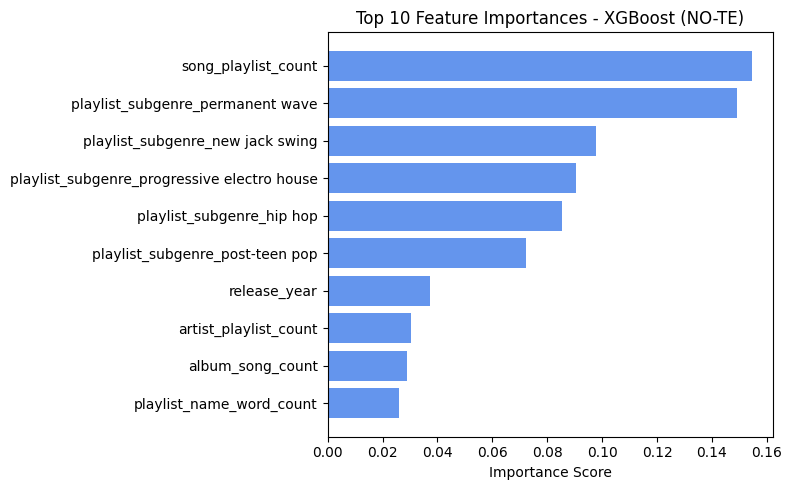

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Build DataFrame of feature importances
imp_no_te = pd.DataFrame({
    "feature": X_train.columns,
    "importance": best_xgb_note.feature_importances_
}).sort_values("importance", ascending=False)

# Print top 10
print("Top 10 important features (NO-TE model):\n")
print(imp_no_te.head(10).to_string(index=False))

# Plot
plt.figure(figsize=(8,5))
plt.barh(imp_no_te.head(10)["feature"], imp_no_te.head(10)["importance"], color="cornflowerblue")
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances - XGBoost (NO-TE)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

In [10]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

import os
save_dir = "/content/drive/MyDrive/Spotify_Project/6_Modeling"
os.makedirs(save_dir, exist_ok=True)

# Save the fine-tuned NO-TE model
best_xgb_note.save_model(f"{save_dir}/xgb_finetuned_model.json")
print("Fine-tuned XGBoost (NO-TE) saved to:", f"{save_dir}/xgb_finetuned_model.json")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Fine-tuned XGBoost (NO-TE) saved to: /content/drive/MyDrive/Spotify_Project/6_Modeling/xgb_finetuned_model.json
